In [282]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense, LSTM,BatchNormalization
from tensorflow import keras

note that change the data source


In [283]:
data = pd.read_csv("D:\\học đại học\\20222\\machine learning\\saved_data.csv")

In [284]:
time=data['Date']
data=data.drop('Date', axis=1)
target="BTC_close"
data=data[3500:]

In [285]:
data.head()

,BTC_close,BTC_open,BTC_high,BTC_low,BTC_volume,Active_Addr_Cnt,Difficulty,Mean_Block_Size(in_bytes),Sum_Block_Weight,Total_Fees(USD),...,ETH,LTC,DOGE,XRP,GOLD,SILVER,COPPER,S&P500,DJI,JP225
3500,10158.4,9701.5,10230.1,9601.6,945.91,783570.0,1.554670e+13,1.129523e+06,516323180.0,313065.534514,...,282.26,77.173,0.002839,0.29801,1603.6,18.192,5773.0,3370.29,29232.19,23193.80
3501,9609.4,10158.6,10230.9,9424.3,905.95,792783.0,1.554670e+13,1.164743e+06,509950989.0,301735.367653,...,259.12,70.782,0.002610,0.27518,1611.8,18.359,5770.0,3386.15,29348.03,23400.70
3502,9602.4,9611.9,9681.4,9448.9,870.80,766448.0,1.554670e+13,1.254015e+06,479225794.0,262146.749017,...,257.39,69.455,0.002651,0.27114,1620.5,18.367,5728.0,3373.23,29219.98,23479.15
3503,9684.5,9602.2,9747.1,9574.5,716.61,768521.0,1.554670e+13,1.065423e+06,511760958.0,230744.225058,...,265.11,73.291,0.002645,0.27422,1648.8,18.579,5765.0,3337.75,28992.41,23386.74
3504,9655.7,9684.5,9706.5,9569.8,589.88,660812.0,1.554670e+13,9.199259e+05,426151034.0,173223.705791,...,261.64,74.818,0.002598,0.27492,1648.8,18.579,5765.0,3337.75,28992.41,23386.74


In [286]:
data.columns

Index(['BTC_close', 'BTC_open', 'BTC_high', 'BTC_low', 'BTC_volume',
       'Active_Addr_Cnt', 'Difficulty', 'Mean_Block_Size(in_bytes)',
       'Sum_Block_Weight', 'Total_Fees(USD)', 'Mean_Hashrate', 'Xfer_Cnt',
       'Mean_Tx_size(native_units)', 'ETH', 'LTC', 'DOGE', 'XRP', 'GOLD',
       'SILVER', 'COPPER', 'S&P500', 'DJI', 'JP225'],
      dtype='object')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


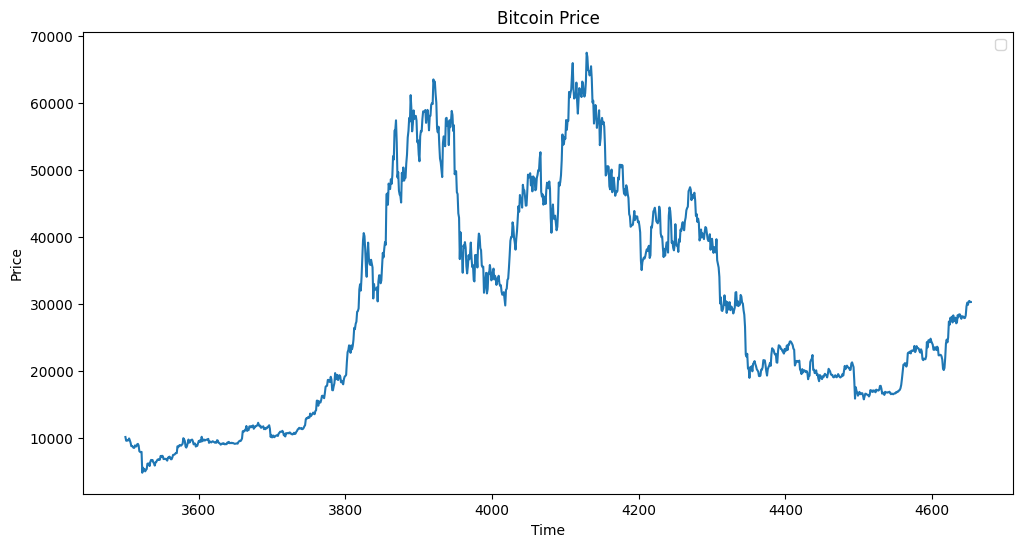

In [287]:
plt.figure(figsize=(12, 6))

plt.plot(data[target])

plt.title('Bitcoin Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [288]:
target=np.array(target)
target.shape

()

splitting data to train, valid, test set

In [289]:
train_data= data.copy().iloc[:int(0.7*len(data)),:]
train_np= train_data.to_numpy()
val_data=data.copy().iloc[int(0.7*len(data)):int(0.85*len(data)),:]
val_np=val_data.to_numpy()
test_data=data.copy().iloc[int(0.85*len(data)):,:]
test_np=test_data.to_numpy()

In [290]:
train_time=time[:int(0.7*len(data))]
val_time=time[int(0.7*len(data)):int(0.85*len(data))]
test_time=time[int(0.85*len(data)):]

In [291]:
train_np = np.asarray(train_np).astype('float32')
val_np = np.asarray(val_np).astype('float32')
test_np = np.asarray(test_np).astype('float32')

In [292]:
time_step=40

In [293]:
scaler=MinMaxScaler()
data_np=data.to_numpy()
scaler.fit(data_np)

MinMaxScaler()

**Create data sequence, sequence length is time step and predict y is the right next day**

In [294]:
def scale_sequence_data(df,timesteps ,close_col_idx,scaler):
    x = []
    y = []
    for i in range(len(df)-timesteps):    
        
        # scaler.fit(df[i:i+timesteps,:])
        x.append(scaler.transform(df[i:i+timesteps,:]))
        value=df[i+timesteps].reshape(1,-1)
        value=scaler.transform(value)
        y.append(value[:,close_col_idx])

    return np.array(x),np.array(y)


In [295]:
train_x, train_y = scale_sequence_data(train_np, time_step,data.columns.get_loc('BTC_close'),scaler)
val_x,val_y =scale_sequence_data(val_np,time_step ,data.columns.get_loc('BTC_close'),scaler)
test_x, test_y = scale_sequence_data(test_np, time_step,data.columns.get_loc('BTC_close'),scaler)

**Build Model**

In [296]:

model = Sequential()
model.add(LSTM(units=100,return_sequences=True,recurrent_dropout=0.3))
model.add(LSTM(units=100,return_sequences =True,recurrent_dropout=0.3))
model.add(LSTM(units=64,return_sequences=False,recurrent_dropout=0.3))
model.add(Dense(16,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
moniter=keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', restore_best_weights=True)
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=1, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])
model.summary()

24/24 [==============================] - 10s 140ms/step - loss: 0.0257 - val_loss: 0.0057
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_40 (LSTM)              (None, 40, 100)           49600     
                                                                 
 lstm_41 (LSTM)              (None, 40, 100)           80400     
                                                                 
 lstm_42 (LSTM)              (None, 64)                42240     
                                                                 
 dense_26 (Dense)            (None, 16)                1040      
                                                                 
 dense_27 (Dense)            (None, 1)                 17        
                                                                 
Total params: 173,297
Trainable params: 173,297
Non-trainable params: 0
_______________________

In [297]:
model.compile(optimizer='adam',loss='MeanSquaredError')
model.fit(train_x,train_y,epochs=20, batch_size=32,validation_data=(val_x,val_y),callbacks=[moniter])

Epoch 1/20
24/24 [==============================] - 9s 142ms/step - loss: 0.0151 - val_loss: 0.0887
Epoch 2/20
24/24 [==============================] - 3s 114ms/step - loss: 0.0076 - val_loss: 0.0410
Epoch 3/20
24/24 [==============================] - 2s 101ms/step - loss: 0.0046 - val_loss: 0.0300
Epoch 4/20
24/24 [==============================] - 3s 113ms/step - loss: 0.0036 - val_loss: 0.0284
Epoch 5/20
24/24 [==============================] - 3s 136ms/step - loss: 0.0032 - val_loss: 0.0298
Epoch 6/20
24/24 [==============================] - 3s 138ms/step - loss: 0.0030 - val_loss: 0.0231
Epoch 7/20
24/24 [==============================] - 3s 139ms/step - loss: 0.0033 - val_loss: 0.0304
Epoch 8/20
24/24 [==============================] - 3s 139ms/step - loss: 0.0024 - val_loss: 0.0344
Epoch 9/20
24/24 [==============================] - 3s 139ms/step - loss: 0.0022 - val_loss: 0.0257
Epoch 10/20
24/24 [==============================] - 3s 136ms/step - loss: 0.0022 - val_loss: 0.0258

In [298]:
model.evaluate(train_x,train_y)
model.evaluate(val_x,val_y)
model.evaluate(test_x,test_y)

5/5 [==============================] - 0s 28ms/step - loss: 0.0111


0.011076458729803562

In [299]:
predictions = model.predict(test_x)
test_y=test_y.reshape(-1,1)

5/5 [==============================] - 1s 24ms/step


In [300]:
predictions.shape

(134, 1)

In [301]:

test_y_reshape = test_y.reshape(-1)
predictions_reshape = predictions.reshape(-1)
mse = mean_squared_error(test_y_reshape, predictions_reshape)
mae = mean_absolute_error(test_y_reshape, predictions_reshape)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


Mean Squared Error (MSE): 0.011076459
Mean Absolute Error (MAE): 0.09322811


In [302]:

mean_absolute_percentage_error(test_y,predictions)

0.39479902

In [303]:
prec_train=model.predict(train_x)
pre_val=model.predict(val_x)

5/5 [==============================] - 0s 25ms/step


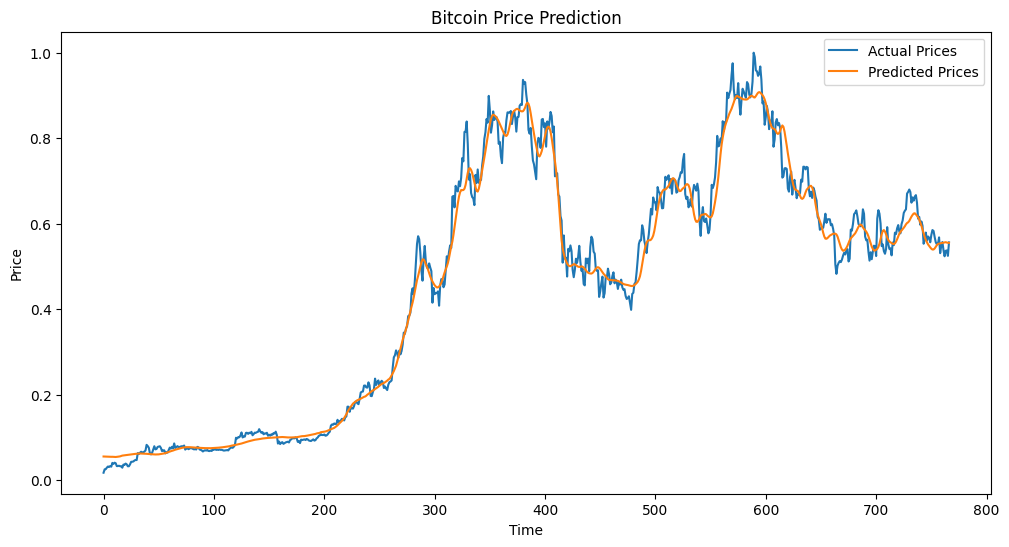

In [304]:
# Plot the predicted and actual prices
plt.figure(figsize=(12,6))
plt.plot(train_y, label='Actual Prices')
plt.plot(prec_train, label='Predicted Prices')

plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

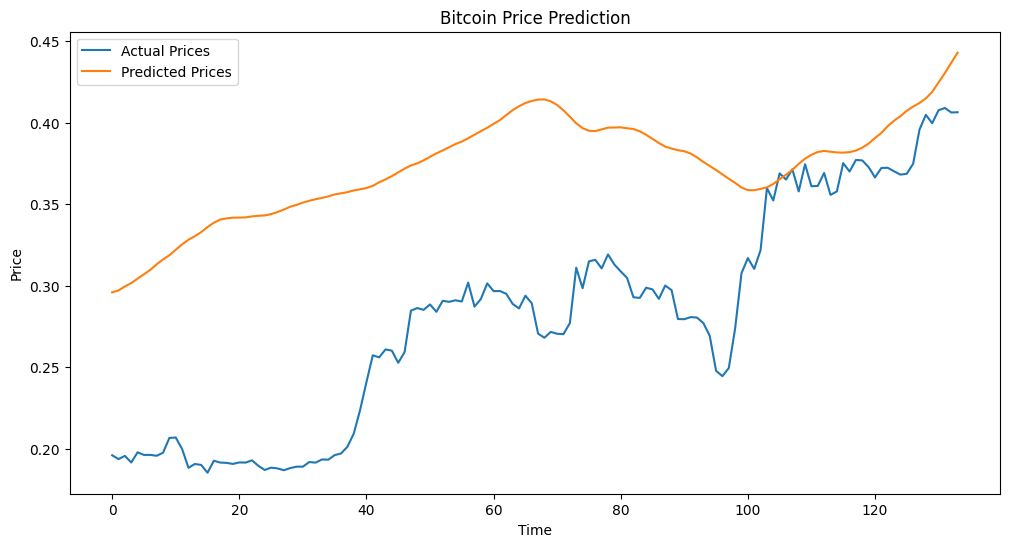

In [305]:

# Plot the predicted and actual prices
plt.figure(figsize=(12,6))
plt.plot(test_y, label='Actual Prices')
plt.plot(predictions, label='Predicted Prices')

plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [307]:
scaler.inverse_transform(test_y)

ValueError: non-broadcastable output operand with shape (134,1) doesn't match the broadcast shape (134,23)